#Обучение классификатора на реальном датасете.

##Пояснение:
Требуется обучить классификатор определяющий тип велосипеда на небольшом датасете фотографий велосипедов из открытых источников. Допускается использовать пред-обученные модели из torchvision.models
По результатам работы составьте отчет.

##Задачи:

* Загрузите Датасет по ссылке: http://fmb.images.gan4x4.ru/hse/bt_dataset3.zip Используйте встроенные классы из пакета torchvision.datasets либо создайте свой являющийся наследником базового класса Dataset из этого пакета.
* Проведите аугментацию данных как минимум 3-мя различными способами. Хотя бы одни из них должен быть реализован самостоятельно.
* Используйте технологию Transfer learning: 
** измените выходной слой выбранной вами предобученной модели.
** Заморозьте часть весов.
* Обучите модель с использование GPU. Учитывайте особенности данных при выборе и настройке Loss-функции
*Оцените результаты.
* Напишите отчет.



*Сохраняйте веса модели на GoogleDrive

In [ ]:
! wget http://fmb.images.gan4x4.ru/hse/bt_dataset3.zip

--2022-12-05 14:09:05--  http://fmb.images.gan4x4.ru/hse/bt_dataset3.zip
Resolving fmb.images.gan4x4.ru (fmb.images.gan4x4.ru)... 212.24.105.216
Connecting to fmb.images.gan4x4.ru (fmb.images.gan4x4.ru)|212.24.105.216|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 110280897 (105M) [application/zip]
Saving to: ‘bt_dataset3.zip’

bt_dataset3.zip     100%[===================>] 105.17M  7.14MB/s    in 42s     

2022-12-05 14:09:47 (2.53 MB/s) - ‘bt_dataset3.zip’ saved [110280897/110280897]



In [ ]:
! unzip bt_dataset3.zip

Archive:  bt_dataset3.zip
   creating: bike/
   creating: bike/bike_type/
   creating: bike/bike_type/train/
   creating: bike/bike_type/train/road/
  inflating: bike/bike_type/train/road/road_4884_5fccd8907cba8.jpeg  
  inflating: bike/bike_type/train/road/road_2553_5fccd83752957.jpeg  
  inflating: bike/bike_type/train/road/road_87_5fccd85402f10.jpeg  
  inflating: bike/bike_type/train/road/road_2457_5fccd81a0919f.jpeg  
  inflating: bike/bike_type/train/road/road_3543_5fccd81d36d22.jpeg  
  inflating: bike/bike_type/train/road/road_85_5fccd8080cc2e.jpeg  
  inflating: bike/bike_type/train/road/road_2515_5fccd8591c9fa.jpeg  
  inflating: bike/bike_type/train/road/road_1965_5fccd81e7e8a4.jpeg  
  inflating: bike/bike_type/train/road/road_2663_5fccd892cdad1.jpeg  
  inflating: bike/bike_type/train/road/road_2297_5fccd83b36a41.jpeg  
  inflating: bike/bike_type/train/road/road_2115_5fccd82b972c0.jpeg  
  inflating: bike/bike_type/train/road/road_2852_5fccd80ab6871.jpeg  
  inflating: bi

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from matplotlib import pyplot as plt
import random
from PIL import Image
from torchvision import models
import torchvision.transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import os
import shutil 

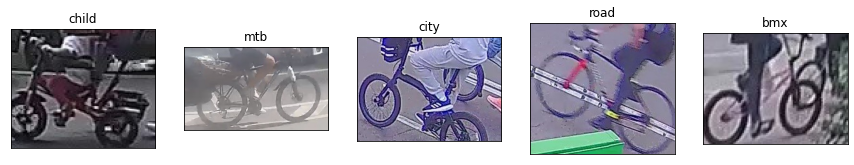

In [ ]:
from skimage import io
img1 = io.imread('/content/bike/bike_type/train/child/child_4211_5fccd84003df7.jpeg')
img2 = io.imread('/content/bike/bike_type/train/mtb/mtb_4102_5fccd88a51aef.jpeg')
img3 = io.imread('/content/bike/bike_type/train/city/city_4798_5fccd7fe83580.jpeg')
img4 = io.imread('/content/bike/bike_type/train/road/road_4841_5fccd8084383b.jpeg')
img5 = io.imread('/content/bike/bike_type/train/bmx/bmx_3399_5fccd7f6183fb.jpeg')

figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,5,1),plt.imshow(img1)
plt.title('child'), plt.xticks([]), plt.yticks([])
plt.subplot(1,5,2),plt.imshow(img2)
plt.title('mtb'), plt.xticks([]), plt.yticks([])
plt.subplot(1,5,3),plt.imshow(img3)
plt.title('city'), plt.xticks([]), plt.yticks([])
plt.subplot(1,5,4),plt.imshow(img4)
plt.title('road'), plt.xticks([]), plt.yticks([])
plt.subplot(1,5,5),plt.imshow(img5)
plt.title('bmx'), plt.xticks([]), plt.yticks([])
plt.show()

такие вот велосипеды.
Загрузка в датасет и преобразования - они рандомизированы, так что будем надеяться на довольно продуктивную аугментацию

In [ ]:
class NormalStatic:
  def __init__(self,  mean = 0, std = 1, p = 0.3):
    self.p = 0.5
    self.mean = mean
    self.std = std

  def __call__(self, x):
    if np.random.random() >= self.p:
      return x
    return x + torch.normal(self.mean, self.std, x.shape)#!

# используем трансформации: стандартные нормализацию и ресайз, преобзование в тензор, автоаугментацию,
# случайное изменение яркости изображения (возможно, фото велосипедов делают летом, когда солнце светит ярко...)
# и случайную перспективу. Не все преобразования применяются с вероятностью 100%, что позволит не слишком зашакалить данные.
# Также применяется кастомная аугментация нормально распределенного шума.
transformations = torchvision.transforms.Compose([
  torchvision.transforms.Resize((224, 224)),
  torchvision.transforms.AutoAugment(),
  torchvision.transforms.ColorJitter(brightness = 2), 
  torchvision.transforms.RandomPerspective(p = 0.3),
  torchvision.transforms.ToTensor(),
  NormalStatic(),
  torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])

# можно и для трейна и для валидации использовать одни и те же трансформации так как они случайны
val_data = ImageFolder("/content/bike/bike_type/val", transform = transformations) 
train_data = ImageFolder("/content/bike/bike_type/train", transform = transformations)

classes = val_data.classes
data_loader = DataLoader(val_data, batch_size=8, shuffle = True)


теперь проанализируем классы, чтобы понимать их баланс или дисбаланс и зависящую от этого стратегию оценки

In [ ]:
in_train = []
in_val = []
for i in range(len(classes)):
  in_train.append(list(train_data.targets).count(i))
  in_val.append(list(val_data.targets).count(i))

class_weights_correction = (100 / torch.tensor(in_train, dtype=torch.float))

print("in train: {} {}, {} {}, {} {}, {} {}, {} {}".format(classes[0], in_train[0],classes[1], in_train[1],classes[2], in_train[2],classes[3], in_train[3],classes[4], in_train[4]))
print("in val  : {} {}, {} {}, {} {}, {} {}, {} {}".format(classes[0], in_val[0],classes[1], in_val[1],classes[2], in_val[2],classes[3], in_val[3],classes[4], in_val[4]))
print("class weights {}".format(class_weights_correction))

in train: bmx 109, child 115, city 714, mtb 1016, road 336
in val  : bmx 3, child 21, city 196, mtb 173, road 68
class weights tensor([0.9174, 0.8696, 0.1401, 0.0984, 0.2976])


наблюдается сильный дисбаланс - будем впоследствии также использовать более чувствительные к выбросам метрики оценки качества, например F1, а также добавим веса к энтропии

### Модели
попробуем несколько, например ResNet, AlexNet и EfficientNet. Для предварительной оценки будем тренировать только 15 эпох, потому что иначе это будет очень долго.

In [ ]:
print(torch.cuda.is_available())
device = torch.device('cuda')

True


In [ ]:
def validate(model, testloader, device):
  correct = 0
  total = 0
  with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
  
  return correct / total  

def train(model, params):
  model.to(device)

  train_loader = DataLoader(train_data, batch_size = 4, shuffle = True)
  val_loader = DataLoader(val_data, batch_size = 4, shuffle = False)

  criterion = nn.CrossEntropyLoss()#weight = class_weights_correction.to(device))
  optimizer = optim.Adam(params, lr=1e-5)#, weight_decay=1e-4)
  best_accuracy = 0

  for epoch in range(15):
    for img_batch, labels_batch in train_loader:
      optimizer.zero_grad()
      output = model(img_batch.to(device))
      loss = criterion(output, labels_batch.to(device))
      loss.backward()
      optimizer.step()
      images = img_batch.cpu()
      label_nums = output.cpu()

    accuracy = validate(model,val_loader,device)
    if best_accuracy < accuracy:
      best_accuracy = accuracy
    print("Epoch {} Loss {:.2f} Accuracy {:.2f}".format(epoch,loss.item(),accuracy))

In [ ]:
model_AlexNet = models.alexnet(pretrained = True)
model_ResNet1 = models.resnet101(pretrained = True)
model_ResNet2 = models.resnet50(pretrained = True)
model_EfficientNet1 = models.efficientnet_b3(pretrained = True)
model_EfficientNet2 = models.efficientnet_b6(pretrained = True)

Делаем transfer learning, дообучая последний слой

In [ ]:
fc_ResNet1 = nn.Linear(model_ResNet1.fc.in_features, len(classes))
model_ResNet1.fc = fc_ResNet1
params_ResNet1 = fc_ResNet1.parameters()

fc_ResNet2 = nn.Linear(model_ResNet2.fc.in_features, len(classes))
model_ResNet2.fc = fc_ResNet2
params_ResNet2 = fc_ResNet2.parameters()

fc_AlexNet = nn.Linear(model_AlexNet.classifier[6].in_features, len(classes))
model_AlexNet.classifier[6] = fc_AlexNet
params_AlexNet = model_AlexNet.classifier.parameters()

model_EfficientNet1.classifier[1] = nn.Linear(model_EfficientNet1.classifier[1].in_features, 5)
params_EfficientNet1 = model_EfficientNet1.classifier.parameters()

model_EfficientNet2.classifier[1] = nn.Linear(model_EfficientNet2.classifier[1].in_features, 5)
params_EfficientNet2 = model_EfficientNet2.classifier.parameters()

model_ResNet1 = model_ResNet1.to(device)
model_ResNet2 = model_ResNet2.to(device)
model_AlexNet = model_AlexNet.to(device)
model_EfficientNet1 = model_EfficientNet1.to(device)
model_EfficientNet2 = model_EfficientNet2.to(device)

In [ ]:
train(model_ResNet1, params_ResNet1)

Epoch 0 Loss 1.01 Accuracy 0.38
Epoch 1 Loss 1.02 Accuracy 0.38
Epoch 2 Loss 0.77 Accuracy 0.38
Epoch 3 Loss 2.01 Accuracy 0.38
Epoch 4 Loss 0.99 Accuracy 0.41
Epoch 5 Loss 1.32 Accuracy 0.37
Epoch 6 Loss 0.82 Accuracy 0.38
Epoch 7 Loss 1.05 Accuracy 0.38
Epoch 8 Loss 2.32 Accuracy 0.36
Epoch 9 Loss 1.93 Accuracy 0.38
Epoch 10 Loss 1.47 Accuracy 0.38
Epoch 11 Loss 0.94 Accuracy 0.38
Epoch 12 Loss 1.95 Accuracy 0.38
Epoch 13 Loss 0.87 Accuracy 0.41
Epoch 14 Loss 0.92 Accuracy 0.36


In [ ]:
train(model_ResNet2, params_ResNet2)

Epoch 0 Loss 0.95 Accuracy 0.37
Epoch 1 Loss 1.08 Accuracy 0.38
Epoch 2 Loss 0.81 Accuracy 0.39
Epoch 3 Loss 1.58 Accuracy 0.37
Epoch 4 Loss 0.93 Accuracy 0.38
Epoch 5 Loss 0.80 Accuracy 0.38
Epoch 6 Loss 1.80 Accuracy 0.39
Epoch 7 Loss 0.82 Accuracy 0.38
Epoch 8 Loss 0.83 Accuracy 0.39
Epoch 9 Loss 1.17 Accuracy 0.38
Epoch 10 Loss 0.97 Accuracy 0.36
Epoch 11 Loss 1.55 Accuracy 0.37
Epoch 12 Loss 1.36 Accuracy 0.36
Epoch 13 Loss 1.15 Accuracy 0.36
Epoch 14 Loss 0.82 Accuracy 0.37


In [ ]:
train(model_AlexNet, params_AlexNet)

Epoch 0 Loss 1.28 Accuracy 0.45
Epoch 1 Loss 1.96 Accuracy 0.47
Epoch 2 Loss 0.83 Accuracy 0.48
Epoch 3 Loss 1.63 Accuracy 0.51
Epoch 4 Loss 0.65 Accuracy 0.49
Epoch 5 Loss 0.15 Accuracy 0.51
Epoch 6 Loss 0.58 Accuracy 0.52
Epoch 7 Loss 1.28 Accuracy 0.52
Epoch 8 Loss 1.46 Accuracy 0.53
Epoch 9 Loss 1.12 Accuracy 0.54
Epoch 10 Loss 0.65 Accuracy 0.54
Epoch 11 Loss 0.21 Accuracy 0.56
Epoch 12 Loss 1.47 Accuracy 0.51
Epoch 13 Loss 0.81 Accuracy 0.56
Epoch 14 Loss 1.03 Accuracy 0.59


In [ ]:
train(model_EfficientNet1, params_EfficientNet1)

Epoch 0 Loss 1.29 Accuracy 0.38
Epoch 1 Loss 0.85 Accuracy 0.36
Epoch 2 Loss 1.12 Accuracy 0.38
Epoch 3 Loss 1.60 Accuracy 0.37
Epoch 4 Loss 1.20 Accuracy 0.38
Epoch 5 Loss 1.27 Accuracy 0.37
Epoch 6 Loss 2.24 Accuracy 0.38
Epoch 7 Loss 0.69 Accuracy 0.37
Epoch 8 Loss 1.25 Accuracy 0.38
Epoch 9 Loss 1.19 Accuracy 0.37
Epoch 10 Loss 1.98 Accuracy 0.38
Epoch 11 Loss 0.88 Accuracy 0.39
Epoch 12 Loss 1.08 Accuracy 0.38
Epoch 13 Loss 1.48 Accuracy 0.38
Epoch 14 Loss 0.81 Accuracy 0.38


In [ ]:
train(model_EfficientNet2, params_EfficientNet2)

Epoch 0 Loss 1.50 Accuracy 0.32
Epoch 1 Loss 1.63 Accuracy 0.31
Epoch 2 Loss 1.34 Accuracy 0.33
Epoch 3 Loss 1.49 Accuracy 0.34
Epoch 4 Loss 1.95 Accuracy 0.32
Epoch 5 Loss 1.29 Accuracy 0.32
Epoch 6 Loss 1.42 Accuracy 0.36
Epoch 7 Loss 2.20 Accuracy 0.35
Epoch 8 Loss 1.39 Accuracy 0.35
Epoch 9 Loss 1.45 Accuracy 0.35
Epoch 10 Loss 1.13 Accuracy 0.34
Epoch 11 Loss 1.72 Accuracy 0.32
Epoch 12 Loss 0.99 Accuracy 0.35
Epoch 13 Loss 1.14 Accuracy 0.36
Epoch 14 Loss 1.02 Accuracy 0.35


Лучше всех себя показала модель , поэтому финально обучать будем ее.
Теперь будем обучать модель 50 эпох, используя при этом scheduler лернинг рейта для выхода с плато, а также будем вычислять f1 для более точной оценки качества модели.

In [ ]:
def validate(model, testloader, device):
  pred = []
  true_labels = []
  prob = []
  with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        res, predicted = torch.max(outputs.data, 1)
        pred.append(predicted)
        true_labels.append(labels)
        prob.append([F.softmax(el, dim = 0) for el in outputs])
  pred = torch.cat(pred).cpu()
  true_labels = torch.cat(true_labels).cpu()
  test_probs = torch.cat([torch.stack(batch) for batch in prob]).cpu()

  accuracy = accuracy_score(true_labels, pred)
  f1 = f1_score(true_labels, pred, average='weighted')
  return (accuracy, f1)


def train(model, params, lr = 1e-5):
  model = model.to(device)

  train_loader = DataLoader(train_data, batch_size = 16, shuffle = True)
  val_loader = DataLoader(val_data, batch_size = 16, shuffle = False)

  writer = SummaryWriter()

  criterion = nn.CrossEntropyLoss(weight = class_weights_correction.to(device))
  optimizer = optim.Adam(params, lr=1e-5, weight_decay=1e-4)
  best_accuracy = 0
  scheduler = ReduceLROnPlateau(optimizer)

  for epoch in range(50):
    for img_batch, labels_batch in train_loader:
      optimizer.zero_grad()
      output = model(img_batch.to(device))
      loss = criterion(output, labels_batch.to(device))
      loss.backward()
      optimizer.step()
      images = img_batch.cpu()
      label_nums = output.cpu()

    scheduler.step(loss.item())
    accuracy, f1 = validate(model, val_loader, device)

    print("Epoch {} Loss {:.2f} Accuracy {:.2f}".format(epoch, loss.item(), accuracy))
    writer.add_scalar('accuracy', accuracy, epoch)
    writer.add_scalar('f1', f1, epoch)
    writer.flush()
  writer.close()

In [ ]:
model_final = models.alexnet(pretrained = True)
fc_final = nn.Linear(model_final.classifier[6].in_features, len(classes))
model_final.classifier[6] = fc_final
params_final = model_final.classifier.parameters()

train(model_final, params_final)

Epoch 0 Loss 0.94 Accuracy 0.26
Epoch 1 Loss 1.18 Accuracy 0.33
Epoch 2 Loss 0.98 Accuracy 0.36
Epoch 3 Loss 0.52 Accuracy 0.34
Epoch 4 Loss 1.69 Accuracy 0.39
Epoch 5 Loss 1.17 Accuracy 0.37
Epoch 6 Loss 1.32 Accuracy 0.38
Epoch 7 Loss 0.86 Accuracy 0.41
Epoch 8 Loss 0.30 Accuracy 0.42
Epoch 9 Loss 0.51 Accuracy 0.35
Epoch 10 Loss 1.25 Accuracy 0.39
Epoch 11 Loss 1.12 Accuracy 0.45
Epoch 12 Loss 0.67 Accuracy 0.43
Epoch 13 Loss 0.53 Accuracy 0.36
Epoch 14 Loss 0.49 Accuracy 0.38
Epoch 15 Loss 1.25 Accuracy 0.45
Epoch 16 Loss 1.54 Accuracy 0.43
Epoch 17 Loss 0.98 Accuracy 0.37
Epoch 18 Loss 2.14 Accuracy 0.46
Epoch 19 Loss 1.46 Accuracy 0.41
Epoch 20 Loss 1.56 Accuracy 0.42
Epoch 21 Loss 1.28 Accuracy 0.46
Epoch 22 Loss 1.34 Accuracy 0.45
Epoch 23 Loss 1.36 Accuracy 0.43
Epoch 24 Loss 1.18 Accuracy 0.43
Epoch 25 Loss 0.98 Accuracy 0.46
Epoch 26 Loss 0.67 Accuracy 0.44
Epoch 27 Loss 0.52 Accuracy 0.45
Epoch 28 Loss 1.69 Accuracy 0.43
Epoch 29 Loss 0.83 Accuracy 0.37
Epoch 30 Loss 1.31 A

как-то не очень здорово выходит, результаты хуже, чем за 15 эпох в прошлый раз. можно попробовать сделать батч меньше, как было в прошлом трейне, и убрать scheduler. далее, если результаты лучше не станут - какие-то из аугментаций

In [ ]:
# smaller batch
def train(model, params, lr = 1e-5):
  model = model.to(device)

  train_loader = DataLoader(train_data, batch_size = 4, shuffle = True)
  val_loader = DataLoader(val_data, batch_size = 4, shuffle = False)

  writer = SummaryWriter()

  criterion = nn.CrossEntropyLoss(weight = class_weights_correction.to(device))
  optimizer = optim.Adam(params, lr=1e-5, weight_decay=1e-4)
  best_accuracy = 0
  scheduler = ReduceLROnPlateau(optimizer)

  for epoch in range(50):
    for img_batch, labels_batch in train_loader:
      optimizer.zero_grad()
      output = model(img_batch.to(device))
      loss = criterion(output, labels_batch.to(device))
      loss.backward()
      optimizer.step()
      images = img_batch.cpu()
      label_nums = output.cpu()

    scheduler.step(loss.item())
    accuracy, f1 = validate(model, val_loader, device)

    print("Epoch {} Loss {:.2f} Accuracy {:.2f}".format(epoch, loss.item(), accuracy))
    writer.add_scalar('accuracy', accuracy, epoch)
    writer.add_scalar('f1', f1, epoch)
    writer.flush()
  writer.close()

In [ ]:
model_final = models.alexnet(pretrained = True)
fc_final = nn.Linear(model_final.classifier[6].in_features, len(classes))
model_final.classifier[6] = fc_final
params_final = model_final.classifier.parameters()

train(model_final, params_final)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 Loss 1.19 Accuracy 0.40
Epoch 1 Loss 0.91 Accuracy 0.49
Epoch 2 Loss 1.34 Accuracy 0.46
Epoch 3 Loss 1.59 Accuracy 0.48
Epoch 4 Loss 2.00 Accuracy 0.41
Epoch 5 Loss 1.12 Accuracy 0.50
Epoch 6 Loss 1.69 Accuracy 0.48
Epoch 7 Loss 1.01 Accuracy 0.51
Epoch 8 Loss 0.89 Accuracy 0.43
Epoch 9 Loss 0.61 Accuracy 0.43
Epoch 10 Loss 1.36 Accuracy 0.51
Epoch 11 Loss 1.08 Accuracy 0.47
Epoch 12 Loss 0.66 Accuracy 0.49
Epoch 13 Loss 0.89 Accuracy 0.46
Epoch 14 Loss 1.11 Accuracy 0.50
Epoch 15 Loss 1.09 Accuracy 0.51
Epoch 16 Loss 1.96 Accuracy 0.45
Epoch 17 Loss 2.59 Accuracy 0.46
Epoch 18 Loss 0.51 Accuracy 0.52
Epoch 19 Loss 1.68 Accuracy 0.51
Epoch 20 Loss 0.72 Accuracy 0.48
Epoch 21 Loss 1.88 Accuracy 0.56
Epoch 22 Loss 1.61 Accuracy 0.51
Epoch 23 Loss 1.13 Accuracy 0.46
Epoch 24 Loss 1.33 Accuracy 0.54
Epoch 25 Loss 0.78 Accuracy 0.51
Epoch 26 Loss 1.27 Accuracy 0.49
Epoch 27 Loss 1.21 Accuracy 0.53
Epoch 28 Loss 0.78 Accuracy 0.56
Epoch 29 Loss 0.40 Accuracy 0.52
Epoch 30 Loss 0.08 A

лучшая аккьюраси - 0.56, это все еще хуже результата 15 эпох в прошлый раз, но лучше чем до этого, то есть меньший батч все-таки лучше

In [ ]:
# no scheduler
def train(model, params, lr = 1e-5):
  model = model.to(device)

  train_loader = DataLoader(train_data, batch_size = 4, shuffle = True)
  val_loader = DataLoader(val_data, batch_size = 4, shuffle = False)

  writer = SummaryWriter()

  criterion = nn.CrossEntropyLoss(weight = class_weights_correction.to(device))
  optimizer = optim.Adam(params, lr=1e-5, weight_decay=1e-4)
  best_accuracy = 0

  for epoch in range(50):
    for img_batch, labels_batch in train_loader:
      optimizer.zero_grad()
      output = model(img_batch.to(device))
      loss = criterion(output, labels_batch.to(device))
      loss.backward()
      optimizer.step()
      images = img_batch.cpu()
      label_nums = output.cpu()

    accuracy, f1 = validate(model, val_loader, device)

    print("Epoch {} Loss {:.2f} Accuracy {:.2f}".format(epoch, loss.item(), accuracy))
    writer.add_scalar('accuracy', accuracy, epoch)
    writer.add_scalar('f1', f1, epoch)
    writer.flush()
  writer.close()

In [ ]:
model_final = models.alexnet(pretrained = True)
fc_final = nn.Linear(model_final.classifier[6].in_features, len(classes))
model_final.classifier[6] = fc_final
params_final = model_final.classifier.parameters()

train(model_final, params_final)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 Loss 0.79 Accuracy 0.43
Epoch 1 Loss 1.11 Accuracy 0.43
Epoch 2 Loss 0.98 Accuracy 0.45
Epoch 3 Loss 1.45 Accuracy 0.45
Epoch 4 Loss 1.82 Accuracy 0.51
Epoch 5 Loss 1.87 Accuracy 0.48
Epoch 6 Loss 0.24 Accuracy 0.49
Epoch 7 Loss 1.99 Accuracy 0.54
Epoch 8 Loss 1.64 Accuracy 0.52
Epoch 9 Loss 1.70 Accuracy 0.49
Epoch 10 Loss 1.77 Accuracy 0.55
Epoch 11 Loss 0.59 Accuracy 0.48
Epoch 12 Loss 0.54 Accuracy 0.51
Epoch 13 Loss 1.53 Accuracy 0.47
Epoch 14 Loss 0.61 Accuracy 0.46
Epoch 15 Loss 2.47 Accuracy 0.52


Без шедулера аккьюраси слегка выше

In [ ]:
# without experimental augmentations
transformations = torchvision.transforms.Compose([
  torchvision.transforms.Resize((224, 224)),
  torchvision.transforms.AutoAugment(),
 # torchvision.transforms.ColorJitter(brightness = 2), 
  torchvision.transforms.RandomPerspective(p = 0.3),
  torchvision.transforms.ToTensor(),
 # NormalStatic(),
  torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])

# можно и для трейна и для валидации использовать одни и те же трансформации так как они случайны
val_data = ImageFolder("/content/bike/bike_type/val", transform = transformations) 
train_data = ImageFolder("/content/bike/bike_type/train", transform = transformations)

classes = val_data.classes
data_loader = DataLoader(val_data, batch_size=8, shuffle = True)

In [ ]:
# smaller batch, no scheduler and decay
def train(model, params, lr = 1e-5):
  model = model.to(device)

  train_loader = DataLoader(train_data, batch_size = 4, shuffle = True)
  val_loader = DataLoader(val_data, batch_size = 4, shuffle = False)

  writer = SummaryWriter()

  criterion = nn.CrossEntropyLoss(weight = class_weights_correction.to(device))
  optimizer = optim.Adam(params, lr=1e-5)
  best_accuracy = 0

  for epoch in range(50):
    for img_batch, labels_batch in train_loader:
      optimizer.zero_grad()
      output = model(img_batch.to(device))
      loss = criterion(output, labels_batch.to(device))
      loss.backward()
      optimizer.step()
      images = img_batch.cpu()
      label_nums = output.cpu()

    accuracy, f1 = validate(model, val_loader, device)

    print("Epoch {} Loss {:.2f} Accuracy {:.2f}".format(epoch, loss.item(), accuracy))
    writer.add_scalar('accuracy', accuracy, epoch)
    writer.add_scalar('f1', f1, epoch)
    writer.flush()
  writer.close()

In [ ]:
model_final = models.alexnet(pretrained = True)
fc_final = nn.Linear(model_final.classifier[6].in_features, len(classes))
model_final.classifier[6] = fc_final
params_final = model_final.classifier.parameters()

train(model_final, params_final)

Epoch 0 Loss 1.00 Accuracy 0.55
Epoch 1 Loss 1.07 Accuracy 0.63
Epoch 2 Loss 1.39 Accuracy 0.63
Epoch 3 Loss 1.01 Accuracy 0.65
Epoch 4 Loss 0.80 Accuracy 0.64
Epoch 5 Loss 1.21 Accuracy 0.68
Epoch 6 Loss 1.25 Accuracy 0.66
Epoch 7 Loss 0.14 Accuracy 0.66
Epoch 8 Loss 0.28 Accuracy 0.70
Epoch 9 Loss 0.54 Accuracy 0.67
Epoch 10 Loss 0.24 Accuracy 0.69
Epoch 11 Loss 0.11 Accuracy 0.63
Epoch 12 Loss 0.30 Accuracy 0.65
Epoch 13 Loss 1.88 Accuracy 0.68
Epoch 14 Loss 0.53 Accuracy 0.70
Epoch 15 Loss 0.04 Accuracy 0.67
Epoch 16 Loss 0.24 Accuracy 0.71
Epoch 17 Loss 0.41 Accuracy 0.69
Epoch 18 Loss 1.53 Accuracy 0.67
Epoch 19 Loss 1.45 Accuracy 0.70
Epoch 20 Loss 0.07 Accuracy 0.70
Epoch 21 Loss 0.12 Accuracy 0.69
Epoch 22 Loss 0.70 Accuracy 0.70
Epoch 23 Loss 1.19 Accuracy 0.63
Epoch 24 Loss 0.28 Accuracy 0.70
Epoch 25 Loss 0.01 Accuracy 0.68
Epoch 26 Loss 0.24 Accuracy 0.72
Epoch 27 Loss 0.11 Accuracy 0.70
Epoch 28 Loss 0.45 Accuracy 0.71
Epoch 29 Loss 0.08 Accuracy 0.76
Epoch 30 Loss 0.27 A

In [1]:
%load_ext tensorboard
%tensorboard --logdir {"runs"}

<IPython.core.display.Javascript object>

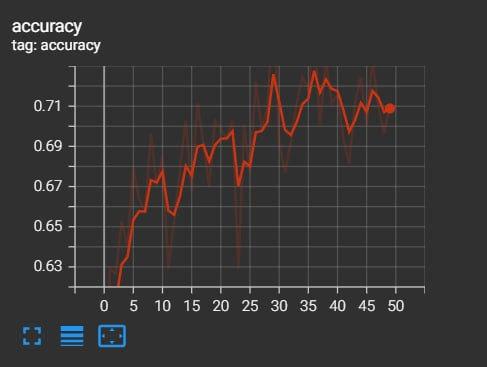

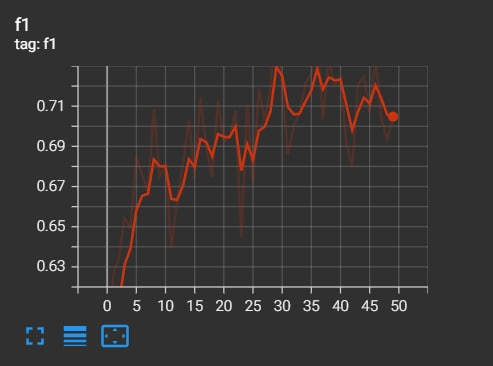

#Отчет
~у меня в очередной раз кончилась GPU хотя я ее включала не дольше чем на 5 часов, так что кусок в середине не досчитался

Кроме этого, результаты вышли не впечатляющие

- на предварительных прогонах лучше всего работала перенесенная модель AlexNet с дообученным последним слоем - результат accuracy 0.59 на 15 эпохе. Результаты четырех остальных моделей - по 2 ResNet и EfficientNet показали сравнимые результаты около 0.35
- добавление дополнительных параметров сильно ослабило модель: AlexNet на 50 эпохах с весами классов, уменьшением learning rate, scheduler-ом и большим батчем дал результат 0.45 в конце. 
- важно отметить, что низкие показатели аккьюраси еще не говорят о том, что модель плохая - например при балансировке весов классов она скорее всего упадет, но модель по факту обучится лучше распознавать малочисленные классы, в связи с чем из финальной модели я веса убирать не стала
- при уменьшении размера бэтчей аккьюраси возросла до 0.56. 
- scheduler не имел какого-то ощутимого эффекта на точность, что с ним, что без него, на 15 эпохе аккьюраси около 0.51.
- последняя модель была обучена на данных, где было меньше аугментаций, а также в модели не было scheduler-а и угасания learning rate, и был меньший бэтч. Она показала самые лучшие результаты - 0.71 в конце.
- при этом, как можно видеть на скриншоте из тензорборда, f1 выглядит примерно как accuracy, что успокаивает хотя бы в равномерном обучении на классах. 
- оба графика крайне турбулентные, вместо того чтобы идти ровно, они очень сильно разбрасываются вверх и вниз. Не совсем понятно, с чем это связано...
- по поводу аугментаций: судя по всему, если их слишком много, то это ослабляет модель, так как полезных данных для анализа становится меньше. Возможно, имеет смысл делать их менее вероятными с одной стороны и менее сильными с другой (например, нормальный шум, который был моей кастомной аугментацией, уменьшить в н раз, чтобы он не так сильно перебивал картинку, аугментацию яркости сделать слабее).
